In [576]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import curve_fit
from uncertainties import ufloat

filename = 'SpinEcho/4.csv'

def get_signals_times_from_file(filename):
    with open(filename) as f:
        reader = csv.reader(f, delimiter = ',')
        header = next(reader)
        times, ch1, ch2, ch3 = [], [], [], []
        for row in reader:
            times.append(float(row[0]))
            ch1.append(float(row[1]))

    times = np.array(times)
    ch1 = np.array(ch1)
    start = -3.
    end = 3.

    range = np.where((times >= start)*(times <= end))
    times = times[range]
    ch1 = ch1[range]
    return times, ch1

def fft_denoise(signals):
    yf = fft(signals)
    # xf = fftfreq(len(times), np.average(np.diff(times)))
    yf[np.abs(yf) < 0.001*np.max(np.abs(yf))] = 0
    # plt.plot(xf, np.abs(yf), linestyle='-', color='blue')
    filtered_signals = np.real(ifft(yf))
    return filtered_signals

def get_freq(times, signals):
    dt = np.average(np.diff(times))
    N = len(times)
    yf = fft(signals)
    xf = fftfreq(N, dt)

    mask = np.where((1600. <= xf)*(xf <= 2400.))
    plt.plot(xf[mask], np.abs(yf[mask]), linestyle='-', color='blue')
    freq = xf[mask][np.argmax(np.abs(yf[mask]))]
    return freq

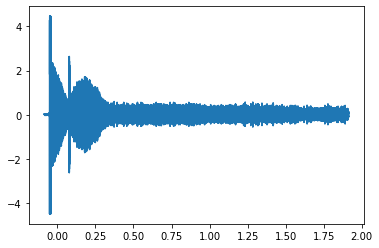

In [577]:
times, signals = get_signals_times_from_file(filename)
plt.plot(times, signals)

Text(0, 0.5, 'signal (V)')

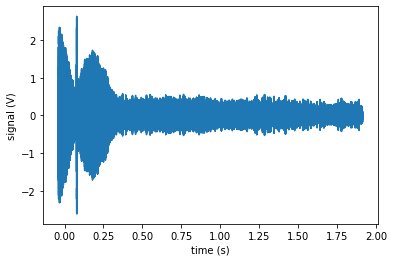

In [578]:
t0 = times[np.argmax(np.abs(signals))]
start = t0 + 0.01
rang = np.where(times >= start)
times = times[rang]
signals = signals[rang]

signals = fft_denoise(signals)

plt.plot(times, signals)

plt.xlabel('time (s)')
plt.ylabel('signal (V)')

In [579]:
t0

-0.050918

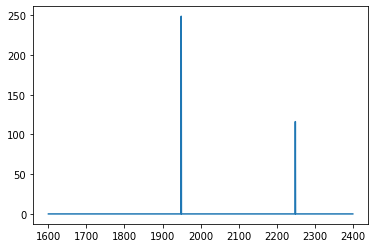

In [580]:
dt = np.average(np.diff(times))
N = len(times)
yf = fft(signals)
xf = fftfreq(N, dt)

mask = np.where((1600. <= xf)*(xf <= 2400.))
plt.plot(xf[mask],np.abs(yf[mask]))


Text(0, 0.5, 'absolute value of FFT signal (V)')

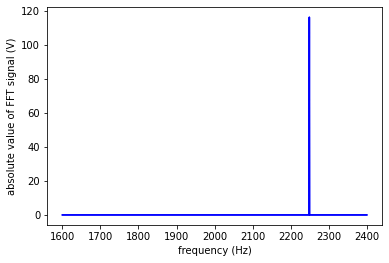

In [581]:
def remove_between(xf, yf,start,end):
    yf_new = np.copy(yf)
    where_to_delete = (start <= xf)*(xf <= end)
    yf_new[where_to_delete] = 0.
    return yf_new

yf = remove_between(xf,yf,1600, 2000)
yf = remove_between(xf,yf,2095, 2105)
yf = remove_between(xf,yf, 2218,2220)
yf = remove_between(xf,yf,2320, 230)

mask = np.where((1600. <= xf)*(xf <= 2400.))
plt.plot(xf[mask], np.abs(yf[mask]), linestyle='-', color='blue')
freq = xf[mask][np.argmax(np.abs(yf[mask]))]

plt.plot(xf[mask], np.abs(yf[mask]), linestyle='-', color='blue')
plt.xlabel('frequency (Hz)')
plt.ylabel('absolute value of FFT signal (V)')
# plt.savefig('fft.png')

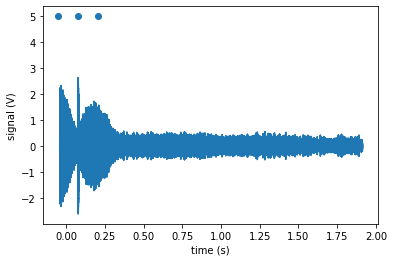

In [582]:
signals = np.real(ifft(yf))
plt.plot(times, signals)
plt.xlabel('time (s)')
plt.ylabel('signal (V)')

dt = 0.1
temp_signals = np.copy(signals)
temp_signals[np.where(times < start + dt)] = 0
t1 = times[np.argmax(np.abs(temp_signals))]
t2 = 2*t1-t0

plt.scatter([t0, t1, t2],[5,5,5])

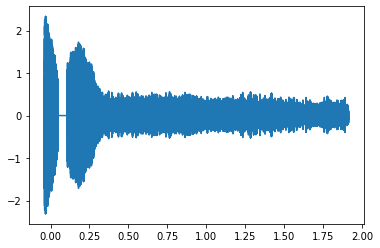

In [583]:
signals = remove_between(times, signals, t1-0.03, t1+0.03)
signals = remove_between(times, signals, 2.0, 3)
plt.plot(times, signals)

a 	 1.59+/-0.06
b 	 0.30+/-0.09
c 	 0.00+/-0.10
te 	 1.216+/-0.015
T2 	 0.280+/-0.013
T3 	 0.50+/-0.21
T4 	 1.2+/-0.5
t0	 -0.050918
t1	 0.078202
t2	 0.20732199999999998
1.2157125034267842 	 0.30982427949055824


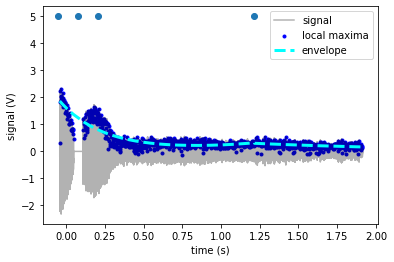

In [584]:
def local_max_filter(times, signals):
    condition = np.where((signals[:-2] < signals[1:-1]) & (signals[1:-1] > signals[2:]))[0] + 1
    return times[condition], signals[condition]

envelope_times = np.copy(times)
envelopes = np.copy(signals)
for i in range(1):
    envelope_times, envelopes = local_max_filter(envelope_times, envelopes)

plt.plot(times, signals, alpha = 0.3, color = 'black', label = 'signal')
plt.scatter(envelope_times[::10], envelopes[::10], color = 'blue', alpha = 1, marker = '.', label = 'local maxima')

def h(x):
    return np.heaviside(x, 0.5)

func = lambda t, a, b, c, te, T2, T3, T4: (a * np.exp(-t/T2) + b * np.exp((t-te)/T3) )* h(-t+te) + b * np.exp(-(t-te)/T4) * h(t-te) + c
popt, pcov = curve_fit(func, envelope_times, envelopes, bounds = (0, np.inf))
plt.plot(envelope_times, func(envelope_times, *popt), color = 'cyan',linestyle = '--' , linewidth = 3, label = 'envelope')

popt_names = ['a', 'b', 'c', 'te', 'T2', 'T3', 'T4']
upopt = [ufloat(est, unc) for est, unc in zip(popt, np.sqrt(np.diag(pcov)))]

for name, u in zip(popt_names,upopt):
    print(name,'\t',u)

print('t0\t', t0)
print('t1\t', t1)
print('t2\t', t2)

plt.scatter([t0, t1, t2, popt[3]],[5,5,5,5])

plt.legend()
plt.xlabel('time (s)')
plt.ylabel('signal (V)')
# plt.savefig('signal2.png')

te = popt[3]
yte = func(te, *popt)

print(te,'\t',yte)

$y=a\exp(-(t-t_0)/T_2) + c$

array([2.97171453, 0.95508559])

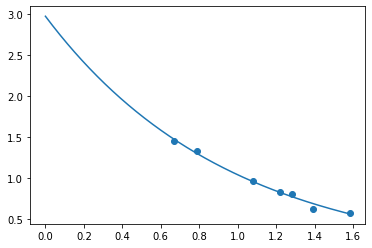

In [585]:
echo_times = [0.79031522,1.283969644,0.666460158,1.078000546,1.221610064,1.392571256,1.583313077]
echo_amps = [1.329003545,0.811534463,1.454685299,0.964582612,0.829072846,0.625603446,0.582465772]

plt.scatter(echo_times, echo_amps)
T2decay = lambda t,a,b: a*np.exp(-t/b)

popt, pcov = curve_fit(T2decay, echo_times, echo_amps)
plt.plot(xs:= np.linspace(0, np.max(echo_times), 1000), ys:=T2decay(xs, *popt))
popt


0.7903152198153244 	 1.3290035452000453 \n
1.2839696438070838 	 0.8115344630394956\n
0.6664601576207203 	 1.454685298745792
1.078000545539607 	 0.9645826117538863
1.2216100643379775 	 0.8290728463165176
1.3925712559973495 	 0.6256034460514837
1.5833130769303532 	 0.582465771635261